In [1]:
import os
import numpy as np
import tensorflow as tf

def load_images(dataset_path, image_size, color_mode="rgb"):  # Added color_mode parameter
    images = []
    labels = []  # Initialize labels list
    celebrity_folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))] # List celebrity folders

    for celebrity_name in celebrity_folders:
        celebrity_path = os.path.join(dataset_path, celebrity_name)
        for file_name in os.listdir(celebrity_path):  # Iterate within the celebrity's folder
            if file_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                img_path = os.path.join(celebrity_path, file_name)
                try:
                    img = tf.keras.utils.load_img(img_path, color_mode=color_mode, target_size=image_size)
                    img_array = tf.keras.utils.img_to_array(img) / 255.0  # Normalize to [0, 1]
                    images.append(img_array)
                    labels.append(celebrity_name) # Append label
                except Exception as e:
                    print(f"Error reading image {img_path}: {e}")

    return np.array(images), np.array(labels) # return labels as well


In [2]:
# Example usage:
dataset_path = os.path.join(os.path.expanduser("~"), "Desktop", r"\Users\Shehab Abdo\Desktop\data_to_be_used/")
image_size = (128, 128)  # Example size
color_mode="grayscale"

images, labels = load_images(dataset_path, image_size, color_mode)

print(f"Loaded {len(images)} images.")
print(f"Loaded {len(labels)} labels.")
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Loaded 8160 images.
Loaded 8160 labels.
Images shape: (8160, 128, 128, 1)
Labels shape: (8160,)


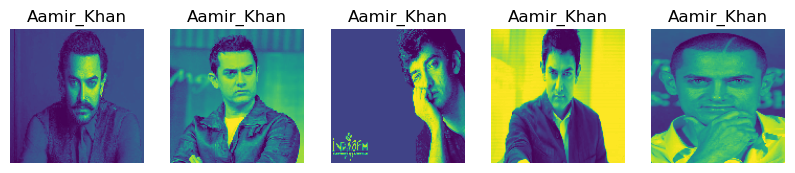

In [3]:
# Example to display some images
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
for i in range(min(5, len(images))): #Display max 5 images
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')
plt.show()


In [4]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

NUM_CLASSES=66
# Split data into training and testing sets (70% training, 30% testing)
x_train, x_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=2)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=2)


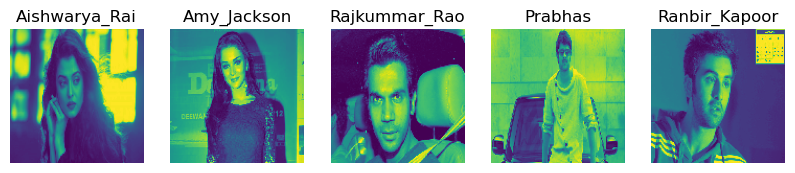

In [5]:
plt.figure(figsize=(10, 5))
for i in range(min(5, len(x_test))): #Display max 5 images
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title(y_train[i])
    plt.axis('off')
plt.show()

x_train shape: (5712, 128, 128, 1)
x_test shape: (1224, 128, 128, 1)
x_val shape: (1224, 128, 128, 1)
y_val shape: (1224,)
y_train shape: (5712,)
y_test shape: (1224,)


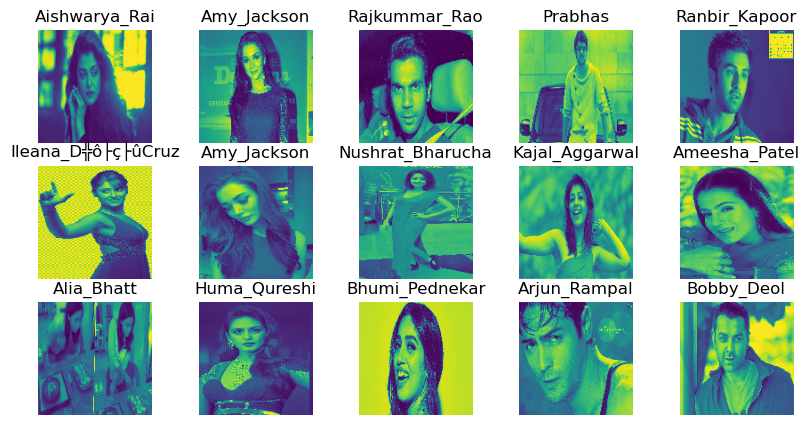

In [6]:
min_val = np.min(x_train)
max_val = np.max(x_train)
x_train = (x_train - min_val) / (max_val - min_val)
x_test = (x_test - min_val) / (max_val - min_val)
x_val = (x_val - min_val) / (max_val - min_val)

print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

plt.figure(figsize=(10, 5))
for i in range(min(15, len(x_test))): #Display max 5 images
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title(y_train[i])
    plt.axis('off')
plt.show()

In [54]:
from tensorflow.keras import layers
def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(inputs)
    x = layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    return tf.keras.Model(inputs, [z_mean, z_log_var], name="encoder")

# Define the sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Define the decoder model
def build_decoder(latent_dim, output_shape):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(32 * 32 * 64, activation='relu')(latent_inputs)
    x = layers.Reshape((32, 32, 64))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
    outputs = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)
    return tf.keras.Model(latent_inputs, outputs, name="decoder")

In [60]:
def vae_loss(z_mean, z_log_var, x, x_reconstructed):
    # Reconstruction loss
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, x_reconstructed))
    reconstruction_loss *= 10  # Scale reconstruction loss
    # KL divergence loss
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    kl_loss = tf.reduce_mean(kl_loss)
    # Total loss
    return reconstruction_loss + kl_loss

# Define the VAE model
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, latent_dim):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()
        self.latent_dim = latent_dim

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling([z_mean, z_log_var])
        reconstructed = self.decoder(z)
        return reconstructed, z_mean, z_log_var

# Training the model
def train_vae(model, train_dataset, val_dataset, epochs, optimizer):
    train_reconstruction_loss = []
    val_reconstruction_loss = []
    train_accuracy = []
    val_accuracy = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Training loop
        train_recon_loss = 0
        correct_reconstructions = 0
        total_samples = 0
        for x_batch in train_dataset:
            with tf.GradientTape() as tape:
                reconstructed, z_mean, z_log_var = model(x_batch)
                reconstruction_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(x_batch, reconstructed)
                )
                kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
                kl_loss = tf.reduce_mean(kl_loss)
                total_loss = reconstruction_loss + kl_loss

            gradients = tape.gradient(total_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            train_recon_loss += reconstruction_loss.numpy()
            total_samples += x_batch.shape[0]

            # Count accurate reconstructions (e.g., MSE < threshold)
            reconstruction_error = tf.reduce_mean(tf.abs(x_batch - reconstructed), axis=(1, 2, 3))
            correct_reconstructions += tf.reduce_sum(tf.cast(reconstruction_error < 0.1, tf.float32)).numpy()

        train_reconstruction_loss.append(train_recon_loss / len(train_dataset))
        train_accuracy.append(correct_reconstructions / total_samples)

        # Validation loop
        val_recon_loss = 0
        val_correct_reconstructions = 0
        val_total_samples = 0
        for x_batch in val_dataset:
            reconstructed, z_mean, z_log_var = model(x_batch)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(x_batch, reconstructed)
            )
            val_recon_loss += reconstruction_loss.numpy()
            val_total_samples += x_batch.shape[0]

            # Count accurate reconstructions
            reconstruction_error = tf.reduce_mean(tf.abs(x_batch - reconstructed), axis=(1, 2, 3))
            val_correct_reconstructions += tf.reduce_sum(tf.cast(reconstruction_error < 0.1, tf.float32)).numpy()

        val_reconstruction_loss.append(val_recon_loss / len(val_dataset))
        val_accuracy.append(val_correct_reconstructions / val_total_samples)

        print(
            f"Epoch {epoch + 1}: Train Loss: {train_reconstruction_loss[-1]:.4f}, "
            f"Val Loss: {val_reconstruction_loss[-1]:.4f} "
        )
        visualize_reconstruction(model, val_dataset)
        
    return train_reconstruction_loss, val_reconstruction_loss#, train_accuracy, val_accuracy

In [48]:
def visualize_reconstruction(model, dataset):
    for x_batch in dataset.take(1):
        reconstructed, _, _ = model(x_batch)
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(x_batch[0, :, :, 0], cmap="gray")
        axes[0].set_title("Original")
        axes[1].imshow(reconstructed[0, :, :, 0], cmap="gray")
        axes[1].set_title("Reconstructed")
        plt.show()
        break

Epoch 1/20
Epoch 1: Train Loss: 0.6873, Val Loss: 0.6880 


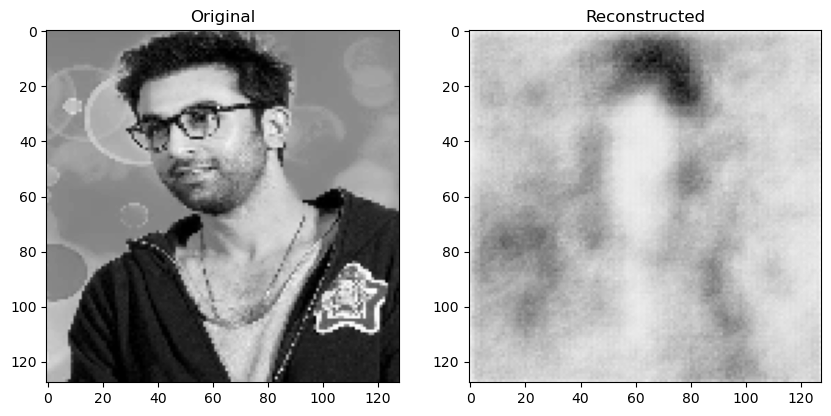

Epoch 2/20
Epoch 2: Train Loss: 0.6865, Val Loss: 0.6874 


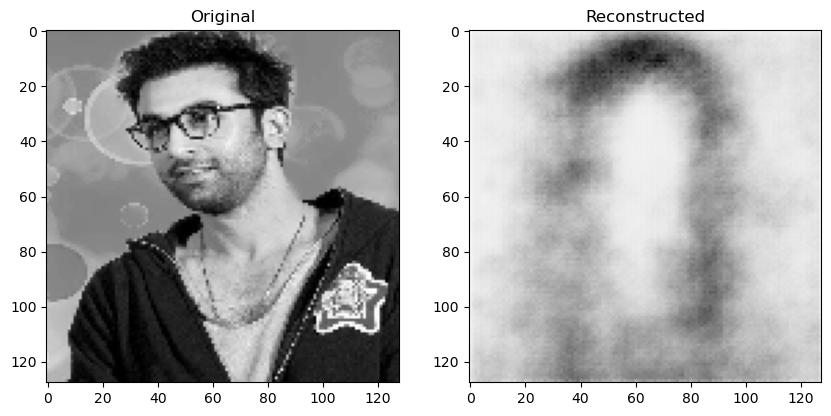

Epoch 3/20
Epoch 3: Train Loss: 0.6862, Val Loss: 0.6874 


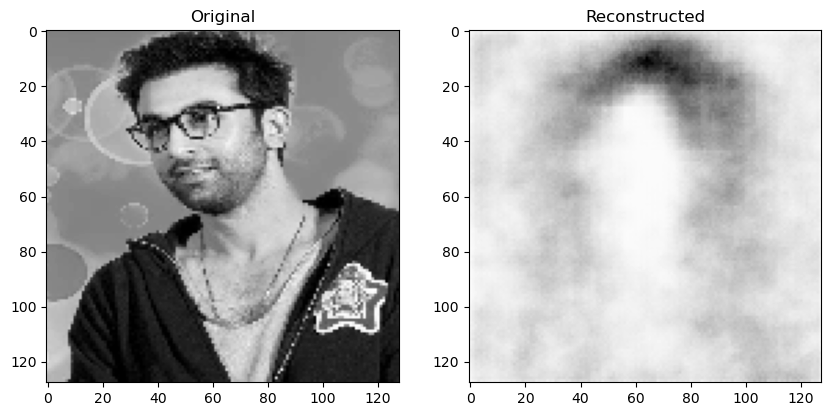

Epoch 4/20
Epoch 4: Train Loss: 0.6860, Val Loss: 0.6872 


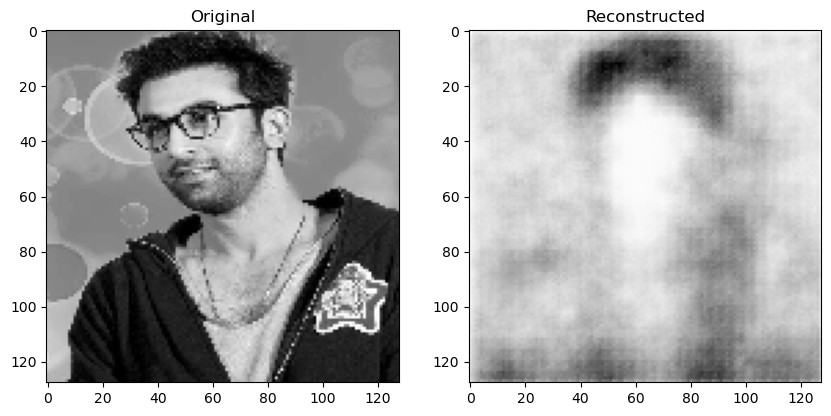

Epoch 5/20
Epoch 5: Train Loss: 0.6858, Val Loss: 0.6872 


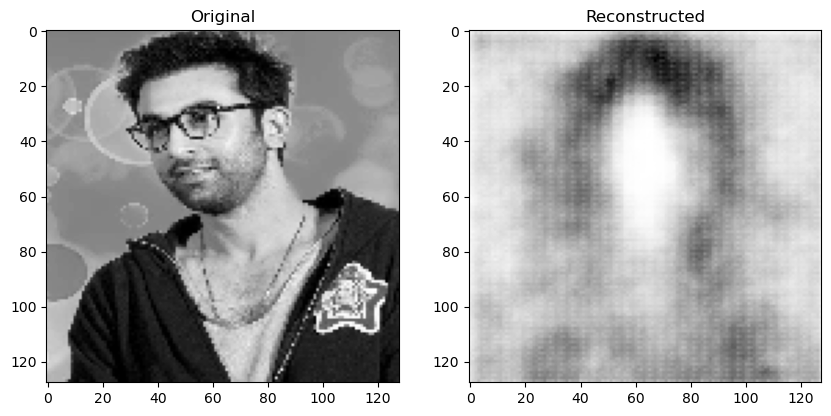

Epoch 6/20
Epoch 6: Train Loss: 0.6858, Val Loss: 0.6867 


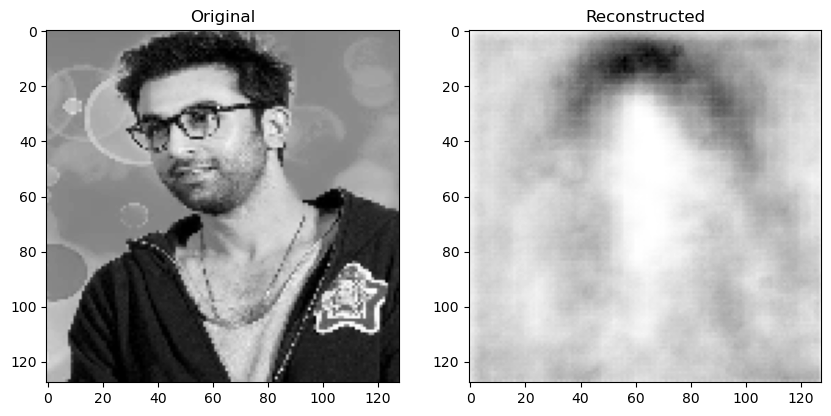

Epoch 7/20
Epoch 7: Train Loss: 0.6857, Val Loss: 0.6872 


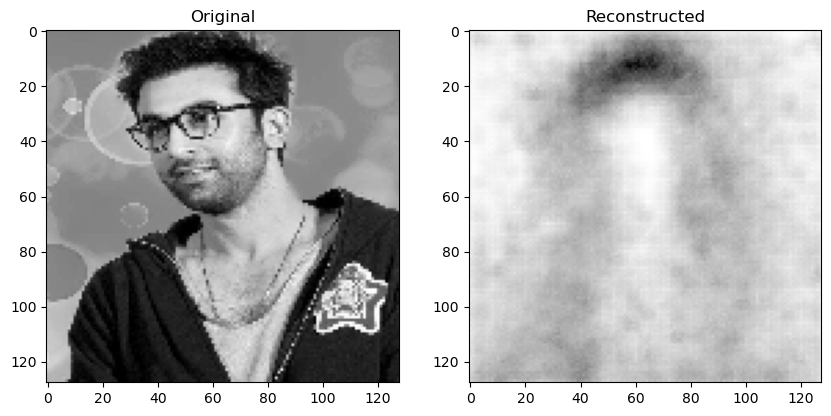

Epoch 8/20
Epoch 8: Train Loss: 0.6856, Val Loss: 0.6869 


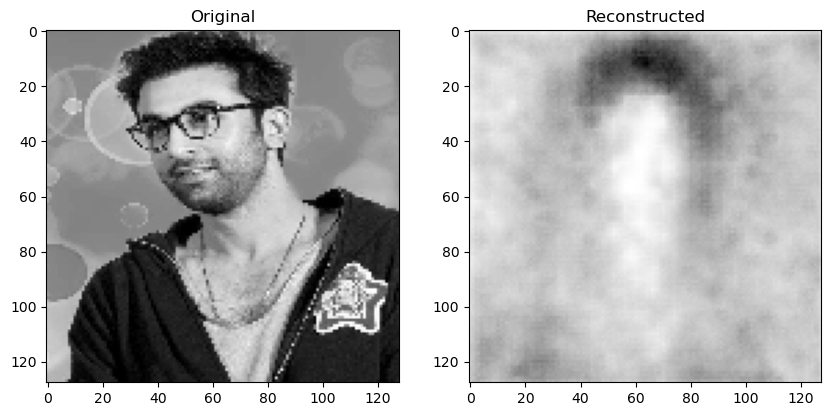

Epoch 9/20
Epoch 9: Train Loss: 0.6857, Val Loss: 0.6880 


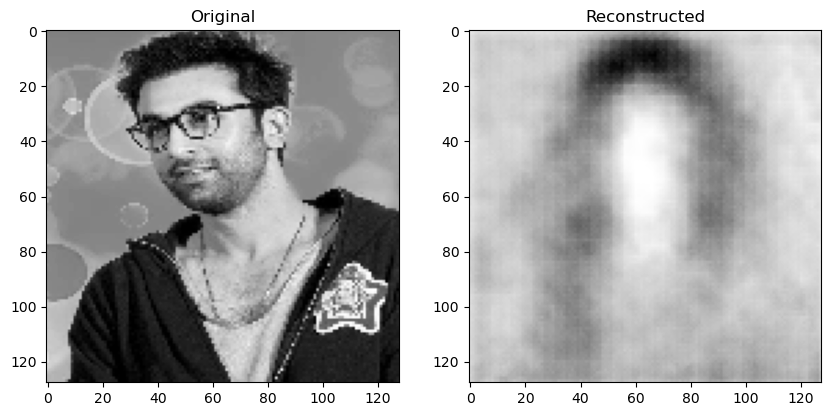

Epoch 10/20
Epoch 10: Train Loss: 0.6856, Val Loss: 0.6871 


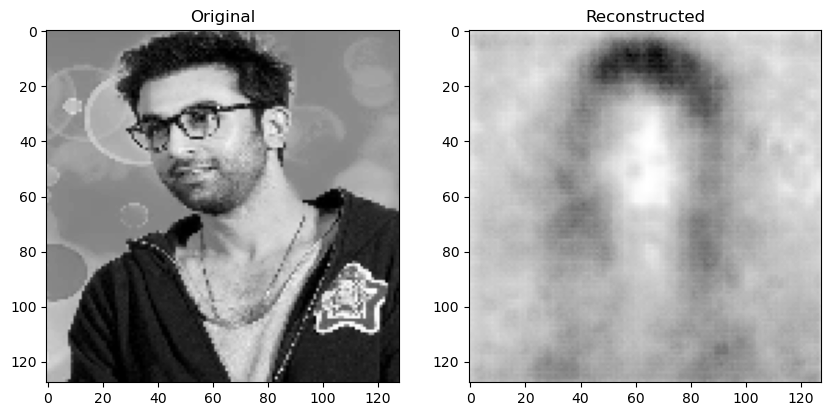

Epoch 11/20
Epoch 11: Train Loss: 0.6856, Val Loss: 0.6867 


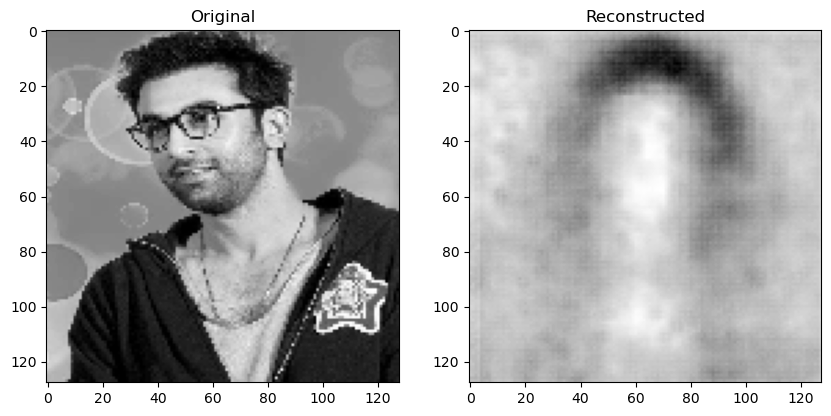

Epoch 12/20
Epoch 12: Train Loss: 0.6855, Val Loss: 0.6869 


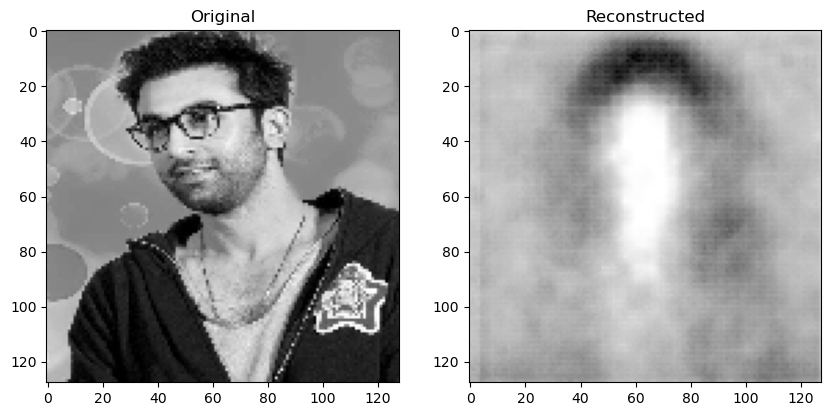

Epoch 13/20
Epoch 13: Train Loss: 0.6855, Val Loss: 0.6865 


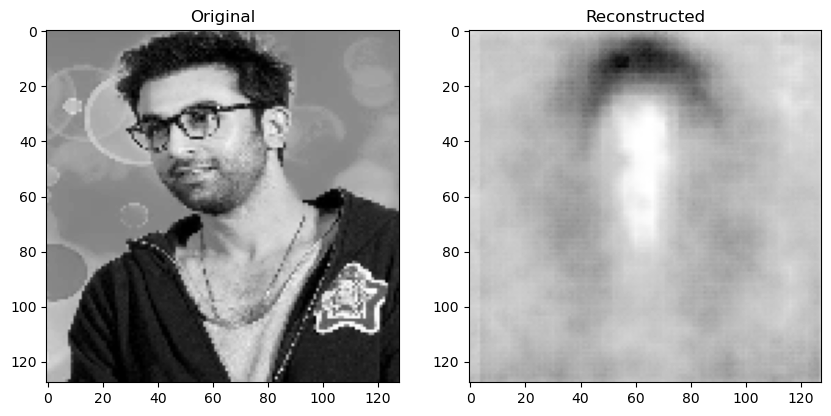

Epoch 14/20
Epoch 14: Train Loss: 0.6855, Val Loss: 0.6868 


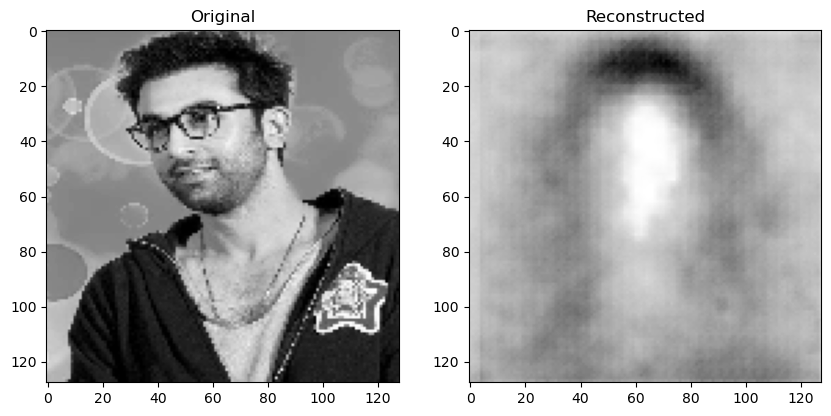

Epoch 15/20
Epoch 15: Train Loss: 0.6854, Val Loss: 0.6870 


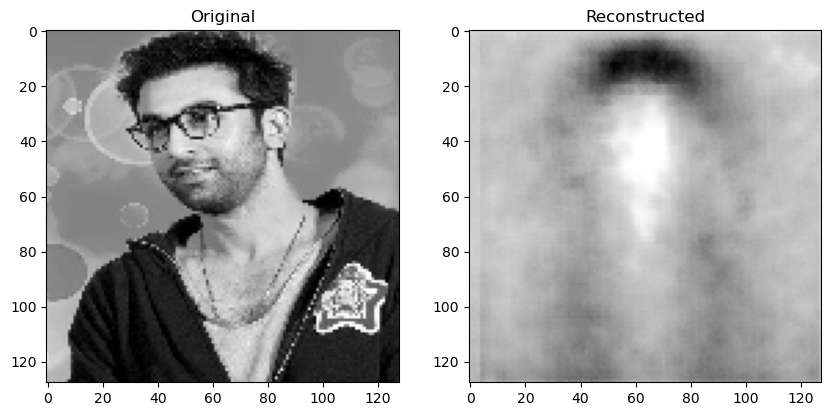

Epoch 16/20
Epoch 16: Train Loss: 0.6855, Val Loss: 0.6866 


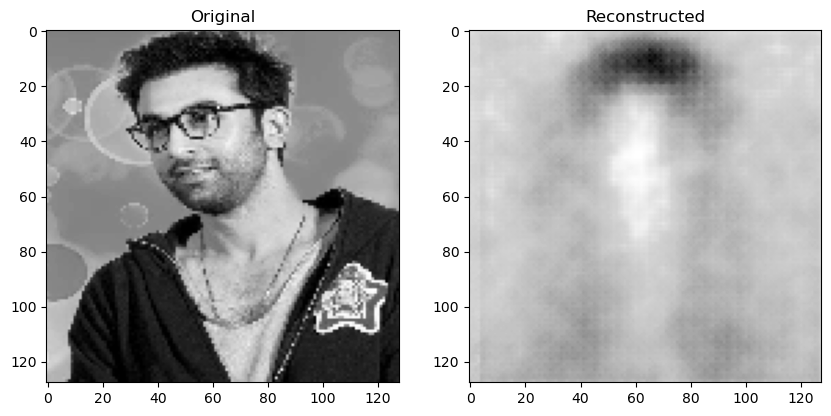

Epoch 17/20
Epoch 17: Train Loss: 0.6853, Val Loss: 0.6868 


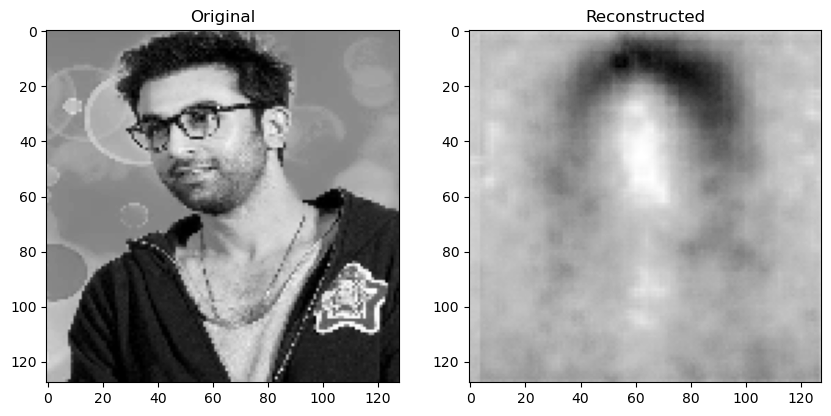

Epoch 18/20
Epoch 18: Train Loss: 0.6853, Val Loss: 0.6869 


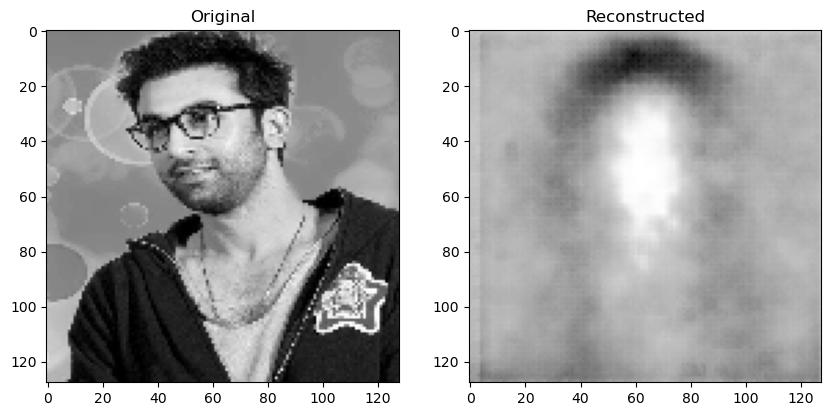

Epoch 19/20
Epoch 19: Train Loss: 0.6853, Val Loss: 0.6867 


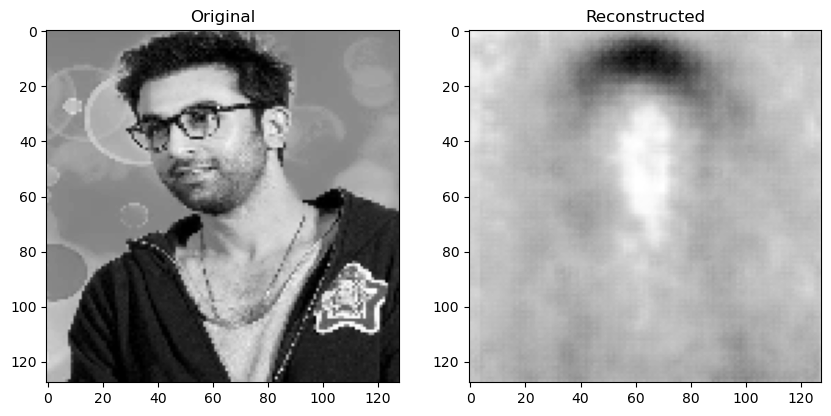

Epoch 20/20
Epoch 20: Train Loss: 0.6854, Val Loss: 0.6868 


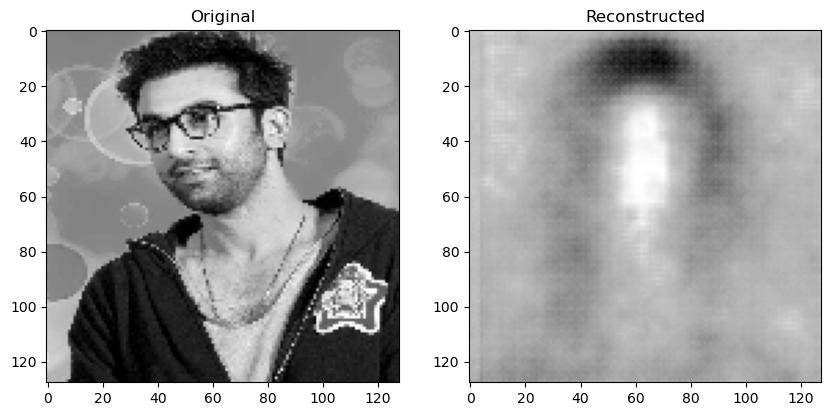

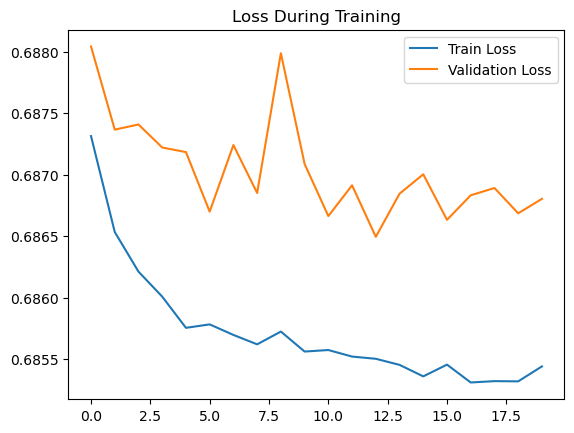

In [61]:
if __name__ == "__main__":
    # Hyperparameters
    latent_dim = 200
    input_shape = (128, 128, 1)
    batch_size = 32
    epochs = 20
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    
    # Create encoder, decoder, and VAE
    encoder = build_encoder(input_shape, latent_dim)
    decoder = build_decoder(latent_dim, input_shape)
    vae = VAE(encoder, decoder, latent_dim)

    train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices(x_val).batch(batch_size)

    # Compile and train
    # Train the VAE
    train_loss, val_loss = train_vae(vae, train_dataset, val_dataset, epochs, optimizer)

    # Plot loss
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.legend()
    plt.title("Loss During Training")
    plt.show()


In [78]:
num_layers_options = [2, 3, 4]  # Number of hidden layers to try
num_nodes_options = [66, 128, 256]  # Number of nodes per layer to try

from sklearn.preprocessing import LabelEncoder

# Label Encoding
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

x_train_2 = x_train.reshape(x_train.shape[0], -1).astype(np.float32)
x_val_2 = x_val.reshape(x_val.shape[0], -1).astype(np.float32)


def build_model(input_shape, num_layers, num_nodes):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=input_shape))
    model.add(tf.keras.layers.Flatten())  # Flatten the input if it's an image
    
    # Add hidden layers
    for _ in range(num_layers):
        model.add(tf.keras.layers.Dense(num_nodes, activation='relu'))
    
    model.add(tf.keras.layers.Dense(66, activation='softmax'))  # Output for classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cross_validate_model(X, y, num_layers_options, num_nodes_options, k=5):
    best_score = -1
    best_config = None
    
    # Initialize KFold
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    for num_layers in num_layers_options:
        for num_nodes in num_nodes_options:
            print(f"Evaluating Model with {num_layers} layers and {num_nodes} nodes per layer...")
            
            fold_scores = []
            
            # Perform k-fold cross-validation
            for train_index, val_index in kfold.split(X):
                # Split data correctly
                x_train_2, x_val_2 = X[train_index], X[val_index]
                y_train_2, y_val_2 = y[train_index], y[val_index]
                
                # Build model
                model = build_model(input_shape=x_train_2.shape[1:], num_layers=num_layers, num_nodes=num_nodes)
                
                # Train model
                model.fit(x_train_2, y_train_2, epochs=10, batch_size=32, verbose=0)
                
                # Evaluate the model on the validation set
                y_pred = model.predict(x_val_2)
                y_pred_classes = np.argmax(y_pred, axis=1)
                fold_accuracy = accuracy_score(y_val_2, y_pred_classes)
                fold_scores.append(fold_accuracy)
            
            # Calculate the mean accuracy for this configuration
            mean_score = np.mean(fold_scores)
            print(f"Mean Accuracy for {num_layers} layers and {num_nodes} nodes: {mean_score:.4f}")
            
            # Check if this configuration is the best
            if mean_score > best_score:
                best_score = mean_score
                best_config = (num_layers, num_nodes)
    
    return best_config, best_score
    
best_config, best_score = cross_validate_model(x_train_2, y_train_2, num_layers_options, num_nodes_options)

print(f"Best configuration: {best_config}")
print(f"Best accuracy: {best_score:.4f}")


Evaluating Model with 2 layers and 66 nodes per layer...


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Mean Accuracy for 2 layers and 66 nodes: 0.0219
Evaluating Model with 2 layers and 128 nodes per layer...


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Mean Accuracy for 2 layers and 128 nodes: 0.0215
Evaluating Model with 2 layers and 256 nodes per layer...


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Mean Accuracy for 2 layers and 256 nodes: 0.0217
Evaluating Model with 3 layers and 66 nodes per layer...


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Mean Accuracy for 3 layers and 66 nodes: 0.0219
Evaluating Model with 3 layers and 128 nodes per layer...


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Mean Accuracy for 3 layers and 128 nodes: 0.0282
Evaluating Model with 3 layers and 256 nodes per layer...


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Mean Accuracy for 3 layers and 256 nodes: 0.0264
Evaluating Model with 4 layers and 66 nodes per layer...


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Mean Accuracy for 4 layers and 66 nodes: 0.0231
Evaluating Model with 4 layers and 128 nodes per layer...


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Mean Accuracy for 4 layers and 128 nodes: 0.0233
Evaluating Model with 4 layers and 256 nodes per layer...


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


C:\Users\Shehab Abdo\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Mean Accuracy for 4 layers and 256 nodes: 0.0280
Best configuration: (3, 128)
Best accuracy: 0.0282


In [103]:
# Label Encoding
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

def build_classifier(input_shape, latent_dim, num_classes):
    # Build the encoder
    encoder = build_encoder(input_shape, latent_dim)
    
    # Get both z_mean and z_log_var
    z_mean, z_log_var = encoder.output
    
    # Concatenate both z_mean and z_log_var
    latent_representation = layers.concatenate([z_mean, z_log_var], axis=-1)
    
    # Add a classification head
    x = layers.Dense(128, activation='relu')(latent_representation)
    x = layers.Dropout(0.6)(x) 
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Use softmax for multi-class classification
    
    # Return the final model
    return tf.keras.Model(encoder.input, outputs, name="classifier")

# Example usage:
input_shape = (128, 128, 1)
latent_dim = 200            # Latent space dimension
num_classes = 66           # Number of classes for classification

classifier_model = build_classifier(input_shape, latent_dim, num_classes)
classifier_model.summary()
classifier_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_82      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │        320 │ input_layer_82[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │     18,496 │ conv2d_22[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_71          │ (None, 65536)     │          0 │ conv2d_23[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_252 (Dense)   │ (None, 512)       │ 33,554,944 │ flatten_71[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 200)       │    102,600 │ dense_252[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 200)       │    102,600 │ dense_252[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 400)       │          0 │ z_mean[0][0],     │
│ (Concatenate)       │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_253 (Dense)   │ (None, 128)       │     51,328 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_253[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_254 (Dense)   │ (None, 66)        │      8,514 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,838,802 (129.08 MB)

 Trainable params: 33,838,802 (129.08 MB)

 Non-trainable params: 0 (0.00 B)

In [104]:
tf.data.experimental.enable_debug_mode()
classifier_history = classifier_model.fit(x_train, y_train_encoded, epochs=4, batch_size=64, validation_data=(x_val,y_val_encoded))
# Evaluate
loss, accuracy = classifier_model.evaluate(x_test, y_test_encoded)
print(f"Classifier model accuracy: {accuracy}")

Epoch 1/4
90/90 ━━━━━━━━━━━━━━━━━━━━ 60s 667ms/step - accuracy: 0.0158 - loss: 4.3711 - val_accuracy: 0.0196 - val_loss: 4.1854
Epoch 2/4
90/90 ━━━━━━━━━━━━━━━━━━━━ 60s 667ms/step - accuracy: 0.0220 - loss: 4.1828 - val_accuracy: 0.0270 - val_loss: 4.1803
Epoch 3/4
90/90 ━━━━━━━━━━━━━━━━━━━━ 60s 664ms/step - accuracy: 0.0294 - loss: 4.1614 - val_accuracy: 0.0359 - val_loss: 4.1533
Epoch 4/4
90/90 ━━━━━━━━━━━━━━━━━━━━ 60s 664ms/step - accuracy: 0.0548 - loss: 4.0146 - val_accuracy: 0.0319 - val_loss: 4.1312
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.0531 - loss: 4.1129
Classifier model accuracy: 0.047385621815919876


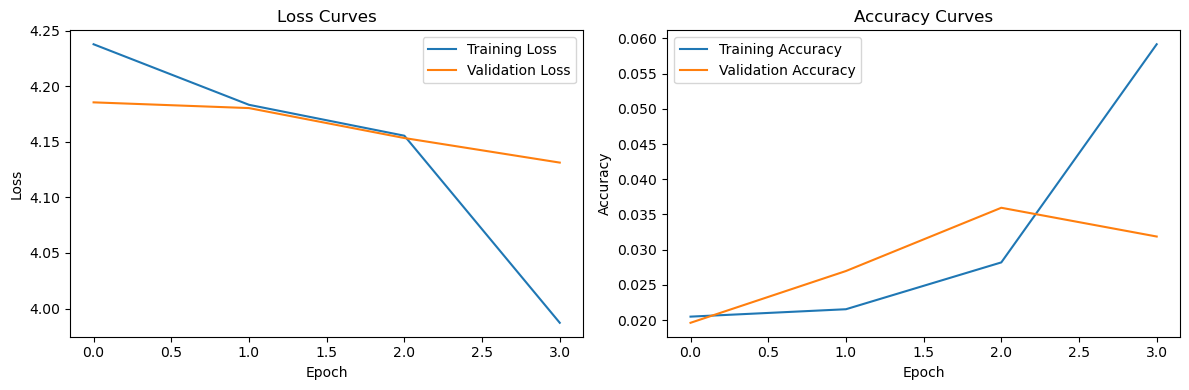

In [105]:
# --- Plotting ---
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(classifier_history.history['loss'], label='Training Loss')
plt.plot(classifier_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(classifier_history.history['accuracy'], label='Training Accuracy')
plt.plot(classifier_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()